## Базова модель - DenseNet121

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Resizing
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


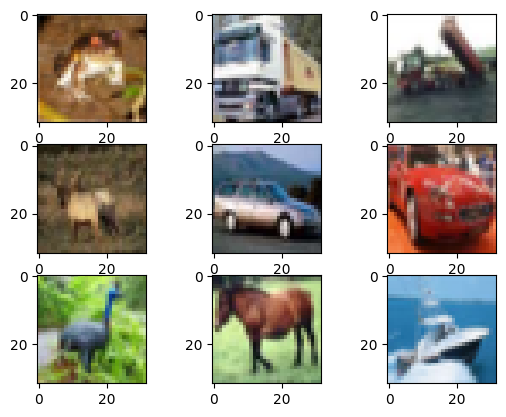

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [3]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.3
    )
datagen.fit(x_train)

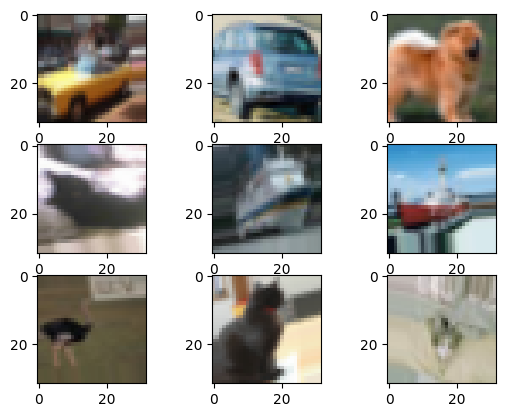

In [4]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [5]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [7]:
# labels
num_classes=10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    Resizing(32, 32, input_shape=(32, 32, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Choose an optimizer
opt = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Check the model structure
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,727,818 (29.48 MB)

 Trainable params: 690,314 (2.63 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
# Зворотні виклики
checkpoint = ModelCheckpoint("DenseNet121_cifar10.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001)

In [10]:
# train with image augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) // 256,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 364ms/step - accuracy: 0.1246 - loss: 3.1745 - val_accuracy: 0.3680 - val_loss: 2.0552 - learning_rate: 1.0000e-04
Epoch 2/100
  1/195 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.2031 - loss: 2.3097

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2031 - loss: 2.3097 - val_accuracy: 0.3685 - val_loss: 2.0540 - learning_rate: 1.0000e-04
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.2049 - loss: 2.1934 - val_accuracy: 0.4527 - val_loss: 1.7895 - learning_rate: 1.0000e-04
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2539 - loss: 2.0057 - val_accuracy: 0.4525 - val_loss: 1.7880 - learning_rate: 1.0000e-04
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - accuracy: 0.2861 - loss: 1.9661 - val_accuracy: 0.4996 - val_loss: 1.5613 - learning_rate: 1.0000e-04
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.3281 - loss: 1.8677 - val_accuracy: 0.5001 - val_loss: 1.5609 - learning_rate: 1.0000e-04
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.3366 - loss: 1.8306 - val_accuracy: 0.5278 - val_loss: 1.4350 - learning_rate: 1.0000e-04
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - ac

In [11]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

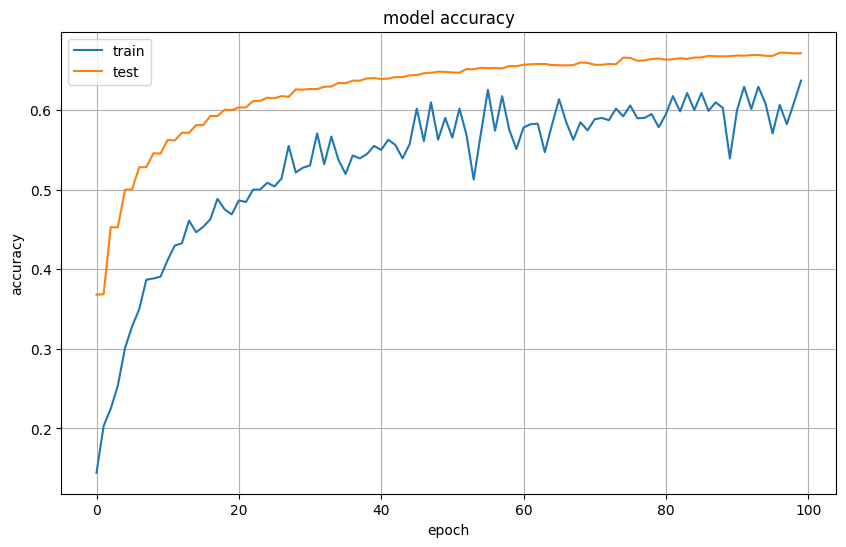

In [12]:
plothist(history)

In [13]:
model_test_acc=model.evaluate(x_test,y_test, batch_size=256)
model_test_acc

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6734 - loss: 0.9450


[0.9471173882484436, 0.6711000204086304]

In [14]:
model_train_acc=model.evaluate(x_train,y_train, batch_size=256)
model_train_acc

196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6956 - loss: 0.8927


[0.8939799070358276, 0.6939799785614014]

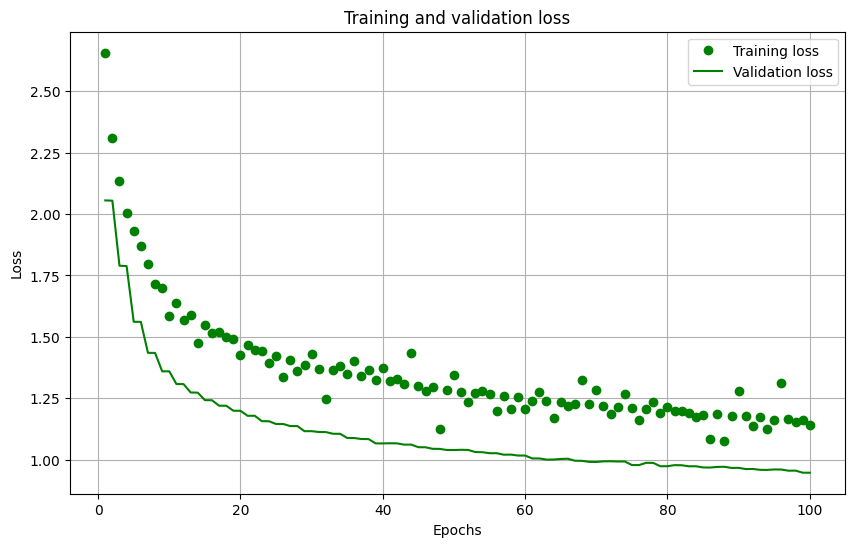

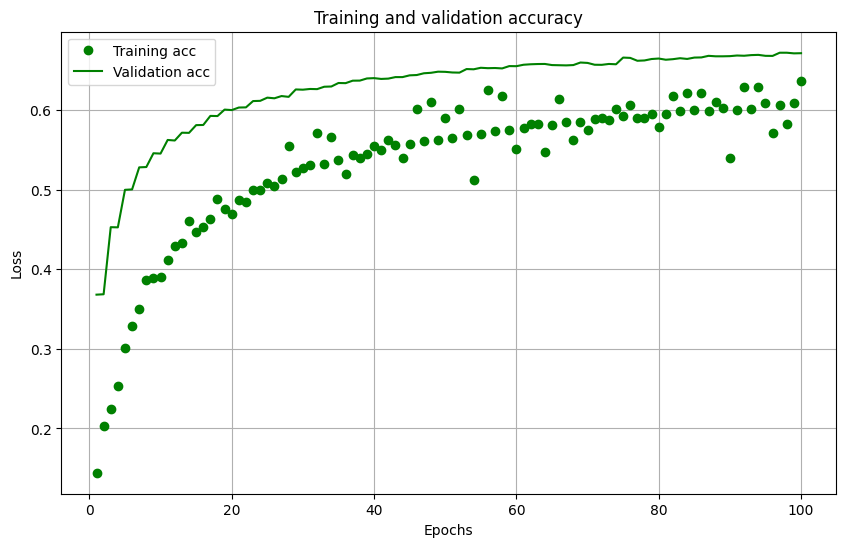

In [15]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Донавчання моделі

In [16]:
# Розмороження останніх декількох шарів DenseNet121
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


# Компіляція моделі з нижчим learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Check the model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,727,818 (29.48 MB)

 Trainable params: 690,314 (2.63 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
# train with image augmentation
history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch=len(x_train) // 256,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 91s 356ms/step - accuracy: 0.6102 - loss: 1.1540 - val_accuracy: 0.6711 - val_loss: 0.9458 - learning_rate: 1.0000e-05
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6367 - loss: 1.0083 - val_accuracy: 0.6711 - val_loss: 0.9458 - learning_rate: 1.0000e-05
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.6124 - loss: 1.1488 - val_accuracy: 0.6714 - val_loss: 0.9454 - learning_rate: 1.0000e-05
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6172 - loss: 1.1434 - val_accuracy: 0.6717 - val_loss: 0.9454 - learning_rate: 1.0000e-05
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - accuracy: 0.6068 - loss: 1.1736 - val_accuracy: 0.6711 - val_loss: 0.9469 - learning_rate: 1.0000e-05
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5938 - loss: 1.2008 - val_accuracy: 0.6710 - val_loss: 0.9468 - learning_rate: 1.0000e-05
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 40s 1

In [18]:
# plotting helper function
def plothist_fine(hist):
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

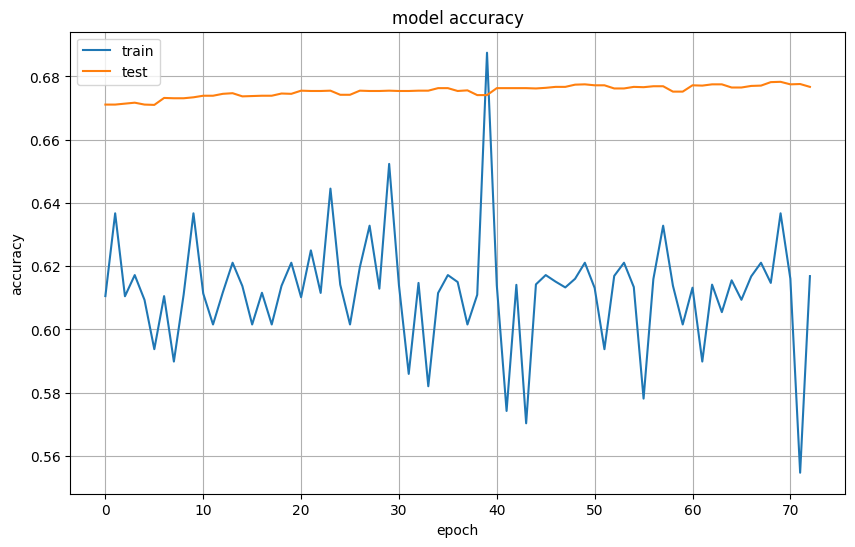

In [19]:
plothist_fine(history_fine)

In [20]:
model_test_acc=model.evaluate(x_test,y_test, batch_size=256)
model_test_acc

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6788 - loss: 0.9324


[0.9347212910652161, 0.6775000095367432]

In [21]:
model_train_acc=model.evaluate(x_train,y_train, batch_size=256)
model_train_acc

196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7006 - loss: 0.8760


[0.8775414824485779, 0.6998000144958496]

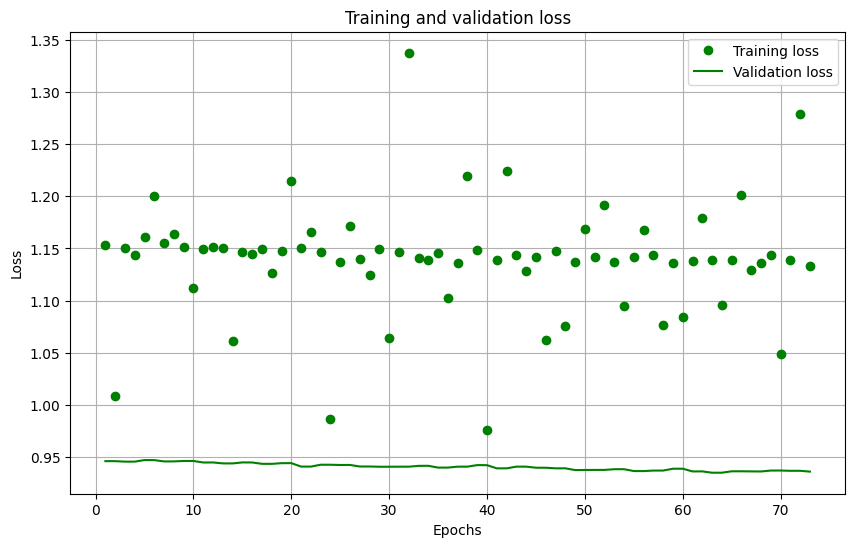

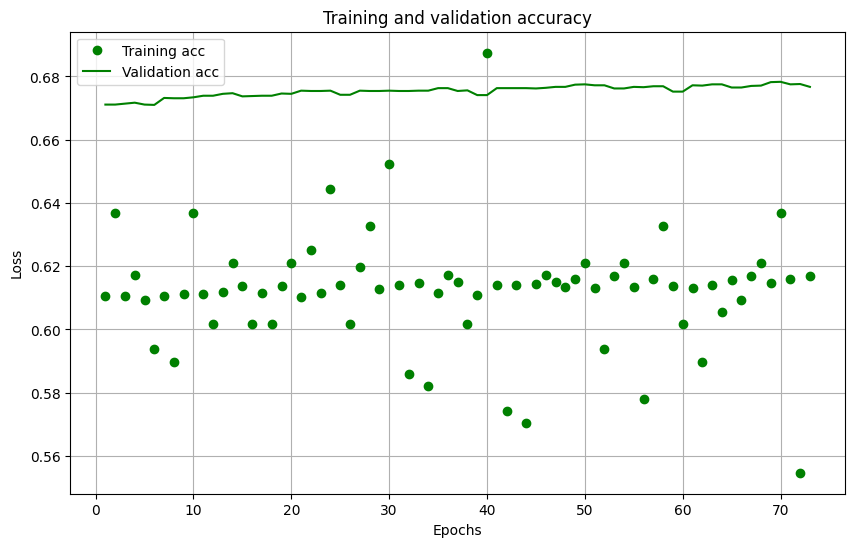

In [22]:
history_fine_dict = history_fine.history
loss_values = history_fine_dict['loss']
val_loss_values = history_fine_dict['val_loss']

epochs = range(1, len(history_fine_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_fine_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_fine_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#Збереження моделі і перевірка роботи

In [23]:
model.save("DenseNet121_cifar10.keras")

In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [25]:
!ls /content

DenseNet121_cifar10.keras  drive  sample_data


In [26]:
!ls '/content/drive/MyDrive/NeuroContact/'

model_notebooks  predict_images


In [27]:
# Переміщення файлу на Google Drive
!cp /content/DenseNet121_cifar10.keras /content/drive/MyDrive/NeuroContact/

In [28]:
# Завантаження моделі
model_path = '/content/drive/MyDrive/NeuroContact/DenseNet121_cifar10.keras'
model = tf.keras.models.load_model(model_path)

ValueError: Layer "dense" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 1, 1, 1024), dtype=float32, sparse=False, name=keras_tensor_1357>, <KerasTensor shape=(None, 1, 1, 1024), dtype=float32, sparse=False, name=keras_tensor_1358>]

In [ ]:
# Завантаження зображення з локального файлу
# Вказати шлях до файлу на Google Диску
img_path = '/content/drive/MyDrive/NeuroContact/predict_images/ship.jpg'

# Завантаження зображення
img = Image.open(img_path)

# Підготовка зображення
img = img.resize((32, 32))  # зміна розміру зображення до розмірів CIFAR-10
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0  # нормалізація зображення

# Передбачення
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Класи CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Виведення результату
print(f"Predicted class: {class_names[predicted_class]}")
plt.imshow(img)
plt.title(f"Predicted class: {class_names[predicted_class]}")
plt.show()